In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation

In [3]:
# Tuning parameters
EPOCHS = 20  # The number of round for training.
BATCH_SIZE = 500
LEARNING_RATE = 1e-3
MSE_THRESHOLD = 1e-2

In [4]:
# Import the data set
data_set = pd.read_csv('data_set_small.csv')

print('The shape of the data set is: ', data_set.shape)

df = pd.DataFrame(data_set)
X_in = df.iloc[:, :13]  # select the first 13 feature columns
y_in = df.iloc[:, 13]  # select the last column

# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_in, y_in,
                                                    test_size = 0.1,
                                                    random_state = 0)

The shape of the data set is:  (19999, 14)


In [5]:
# Build a feed-forward DNN
input_dim = X_in.shape[1]

# Input layer
model = tf.keras.Sequential()
# Hidden layers
model.add(tf.keras.layers.Dense(128,
                             activation = 'relu',
                             input_shape = (input_dim,),
                             kernel_initializer = 'normal'))
model.add(tf.keras.layers.Dense(128,
                             activation = 'relu',
                             kernel_initializer = 'normal'))
model.add(tf.keras.layers.Dense(128,
                             activation = 'relu',
                             kernel_initializer = 'normal'))
model.add(tf.keras.layers.Dense(128,
                             activation = 'relu',
                             kernel_initializer = 'normal'))
model.add(tf.keras.layers.Dense(128,
                             activation = 'relu',
                             kernel_initializer = 'normal'))
# Output layer
model.add(tf.keras.layers.Dense(1,
                             activation = 'linear',
                             kernel_initializer = 'normal'))

# Improve the training by reducing the learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 5,
                              min_lr = 1e-10)

optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)

model.compile(optimizer = optimizer,
              loss = 'mse',
              metrics = ['mse'])


print('The structure of the DNN model is: \n', model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 67,969
Trainable params: 67,969
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
history = model.fit(X_train, y_train,
                    validation_split = 0.1,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [reduce_lr],
                    verbose = 0
                    )

print(history.history.keys())  # check metric keys before plotting

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


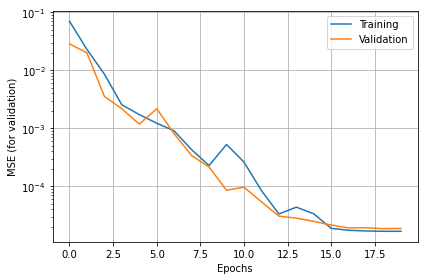

In [8]:
plt.figure(figsize = (6, 4))  # set figure ratio
plt.plot(history.history['mse'], label = 'Training')
plt.plot(history.history['val_mse'], label = 'Validation'),
plt.yscale('log')
plt.grid(True)
plt.ylabel('MSE (for validation)')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')
plt.tight_layout()  # avoid missing x-label or y-label
plt.savefig('fig_validation.pdf', format = 'pdf')
plt.show()

In [9]:
# Save the trained DNN model
model.save('trained_DNN.h5')

In [10]:
# verify the trained model
model_trained = keras.models.load_model('trained_DNN.h5')
y_pred = model_trained.predict(X_test)

# Compute the RMSE
RMSE_trained = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE is: ', RMSE_trained)

if RMSE_trained < MSE_THRESHOLD:
    print('Qualified trained model!')
else:
    print('Re-train the model.')

RMSE is:  0.004244320124381034
Qualified trained model!


In [11]:
# -------------------------------------------------------
# Get predicted results after the trained model is qualified

if RMSE_trained < MSE_THRESHOLD:
    # Load the qualified trained model
    model_trained_qualified = \
        keras.models.load_model('trained_DNN.h5')
    
    # Input parameters
    snrdB    = [-10, -8, -6, -4, -2,
                0, 2, 4, 6, 8, 10, 12,
                14, 16, 18, 20]  #1 snrdB
    N        = 20 #2
    omegaR   = 1 #3
    rR       = 1 #4
    hR       = 1 #5
    m_Sr     = 2.5 #6
    m_rD     = 2.5 #7
    alpha_Sr = 3 #8
    alpha_rD = 3 #9
    beta_Sr  = 1 #10
    beta_rD  = 1 #11
    eta      = 1 #12
    R_th     = 5 #13
    
    out_put = np.zeros((len(snrdB),1))
    
    for idx in np.arange(len(snrdB)):
        input_parameters = [snrdB[idx], N, omegaR, rR, hR,
                            m_Sr, m_rD, alpha_Sr, alpha_rD,
                            beta_Sr, beta_rD, eta, R_th]
        X_test = np.array(input_parameters).reshape(1, -1)
        y_predict = model_trained_qualified.predict(X_test)
        out_put[idx] = np.abs(y_predict)
        print('Prediction P_out is ', np.abs(y_predict),
              'when PS_dB is', snrdB[idx])
    
    print('All outputs are: \n', out_put)

Prediction P_out is  [[1.0142542]] when PS_dB is -10
Prediction P_out is  [[0.9969195]] when PS_dB is -8
Prediction P_out is  [[0.9867813]] when PS_dB is -6
Prediction P_out is  [[0.97577626]] when PS_dB is -4
Prediction P_out is  [[0.9357483]] when PS_dB is -2
Prediction P_out is  [[0.7945438]] when PS_dB is 0
Prediction P_out is  [[0.5771429]] when PS_dB is 2
Prediction P_out is  [[0.29511613]] when PS_dB is 4
Prediction P_out is  [[0.0900092]] when PS_dB is 6
Prediction P_out is  [[0.01601804]] when PS_dB is 8
Prediction P_out is  [[0.00142307]] when PS_dB is 10
Prediction P_out is  [[0.00056921]] when PS_dB is 12
Prediction P_out is  [[0.00010989]] when PS_dB is 14
Prediction P_out is  [[0.00013184]] when PS_dB is 16
Prediction P_out is  [[8.5603446e-05]] when PS_dB is 18
Prediction P_out is  [[0.00010815]] when PS_dB is 20
All outputs are: 
 [[1.01425421e+00]
 [9.96919513e-01]
 [9.86781299e-01]
 [9.75776255e-01]
 [9.35748279e-01]
 [7.94543803e-01]
 [5.77142894e-01]
 [2.95116127e-0